BOUNDARIES DETECTION:

here we compute the boundary mask on the ground truth segmentation labels, to tell the model “this is a boundary region, pay more attention here”

to do that we use morphological gradient (difference between the dilation and the erosion of the image)
dilation: expand the region of each class, boundary pixels move away from the center of the region (each pixel replaced with maximum value in its neighborhood)
erosion: reduce the region of each class, boundary pixels move toward the center of the region (each pixel replaced with minimum value in its neighborhood)

In [13]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
def get_boundary_mask(label_mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(label_mask, kernel, iterations=2)
    eroded = cv2.erode(label_mask, kernel, iterations=2)
    boundary = (dilated != eroded).astype(np.uint8)
    return boundary

In [15]:
input_path = "../gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png"
label_mask = np.array(Image.open(input_path))

boundary = get_boundary_mask(label_mask)

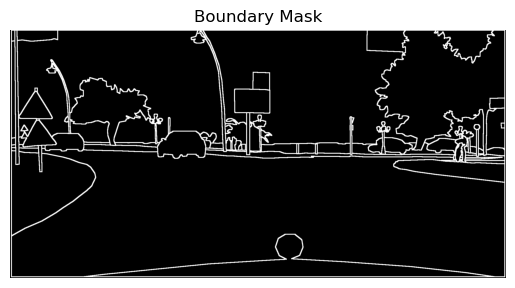

In [16]:
plt.figure()
plt.imshow(boundary, cmap='gray')
plt.title("Boundary Mask")
plt.axis('off')
plt.show()

to understand the concept look at teh cells below

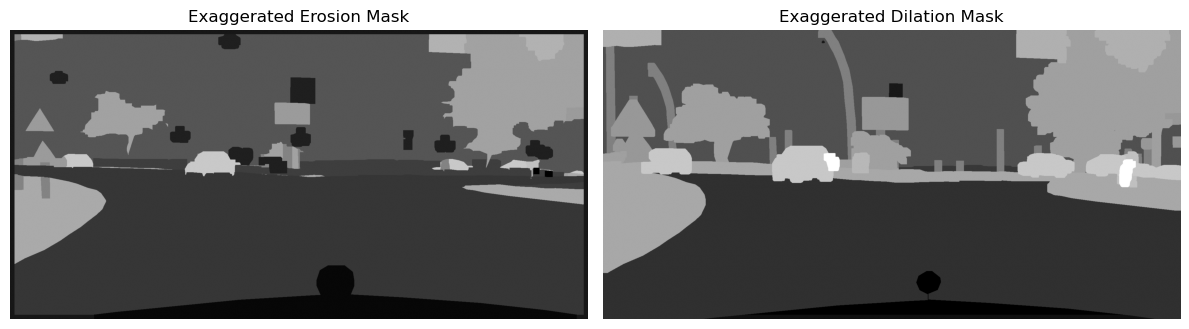

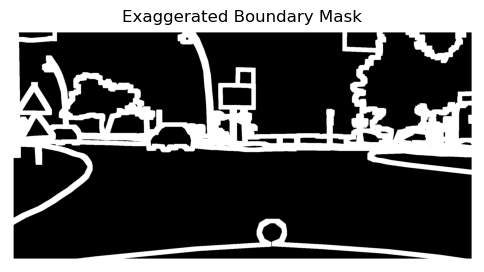

In [17]:
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(label_mask, kernel, iterations=10)
dilation = cv2.dilate(label_mask, kernel, iterations=10)
boundary = (dilation != erosion).astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(erosion, cmap='gray')
axs[0].set_title("Exaggerated Erosion Mask")
axs[0].axis('off')
axs[1].imshow(dilation, cmap='gray')
axs[1].set_title("Exaggerated Dilation Mask")
axs[1].axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(boundary, cmap='gray')
plt.title("Exaggerated Boundary Mask")
plt.axis('off')
plt.show()

BOUNDARY AWARE BCE:

following the format of how to create a custom loss function according to:
https://medium.com/we-talk-data/crafting-custom-loss-functions-in-pytorch-an-advanced-guide-830ff717163e

lambda_weight: weight lambda of the formula
pred: tensor of the outputs of the sigmoid head, the dimension is (B, C, H, W) with B batch size, C classes ...
target: ground truth one hot encoded with dimension (B, C, H, W)
boundary_mask: mask computed using get_boundary_mask() where 1 indicates boundary pixel, dimension (B, 1, H, W)

In [18]:
import torch
import torch.nn as nn

In [19]:
class BoundaryAwareBCELoss(nn.Module):
    def __init__(self, lambda_weight=3.0):
        super().__init__()
        self.lambda_weight = lambda_weight

    def forward(self, pred, target, boundary_mask):
        #to avoid log(0)
        eps = 1e-7

        #standard BCE loss
        bce = -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
        normal_term = bce.mean()

        boundary_mask = boundary_mask.float()                                      #to keep??
        #expansion to (B, C, H, W) to do the multiplication
        boundary_mask = boundary_mask.expand(-1, pred.shape[1], -1, -1)

        #boundary aware BCE loss
        boundary_bce = bce * boundary_mask
        boundary_pixels = boundary_mask.sum(dim=(1, 2, 3)).clamp(min=1.0) #boundary pixels of each image
        boundary_loss = boundary_bce.sum(dim=(1, 2, 3)) / boundary_pixels
        boundary_term = boundary_loss.mean()

        return normal_term + self.lambda_weight * boundary_term
    